In [3]:
import os
print(os.listdir('./output'))

['lele', 'mujair', 'nila']


In [4]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [5]:
X=[]
Z=[]
IMG_SIZE=150
LELE_DIR='./output/lele'
MUJAIR_DIR='./output/mujair'
NILA_DIR='./output/nila'

In [6]:
def assign_label(img,fish_species):
    return fish_species
    

In [7]:
def make_train_data(fish_species,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,fish_species)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [8]:
make_train_data('Lele',LELE_DIR)
print(len(X))

100%|██████████| 800/800 [00:02<00:00, 318.90it/s]

800


In [9]:
make_train_data('Nila',NILA_DIR)
print(len(X))

100%|██████████| 800/800 [00:01<00:00, 454.10it/s]

1600


In [10]:
make_train_data('Mujair',MUJAIR_DIR)
print(len(X))

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [00:02<00:00, 369.29it/s]

2400


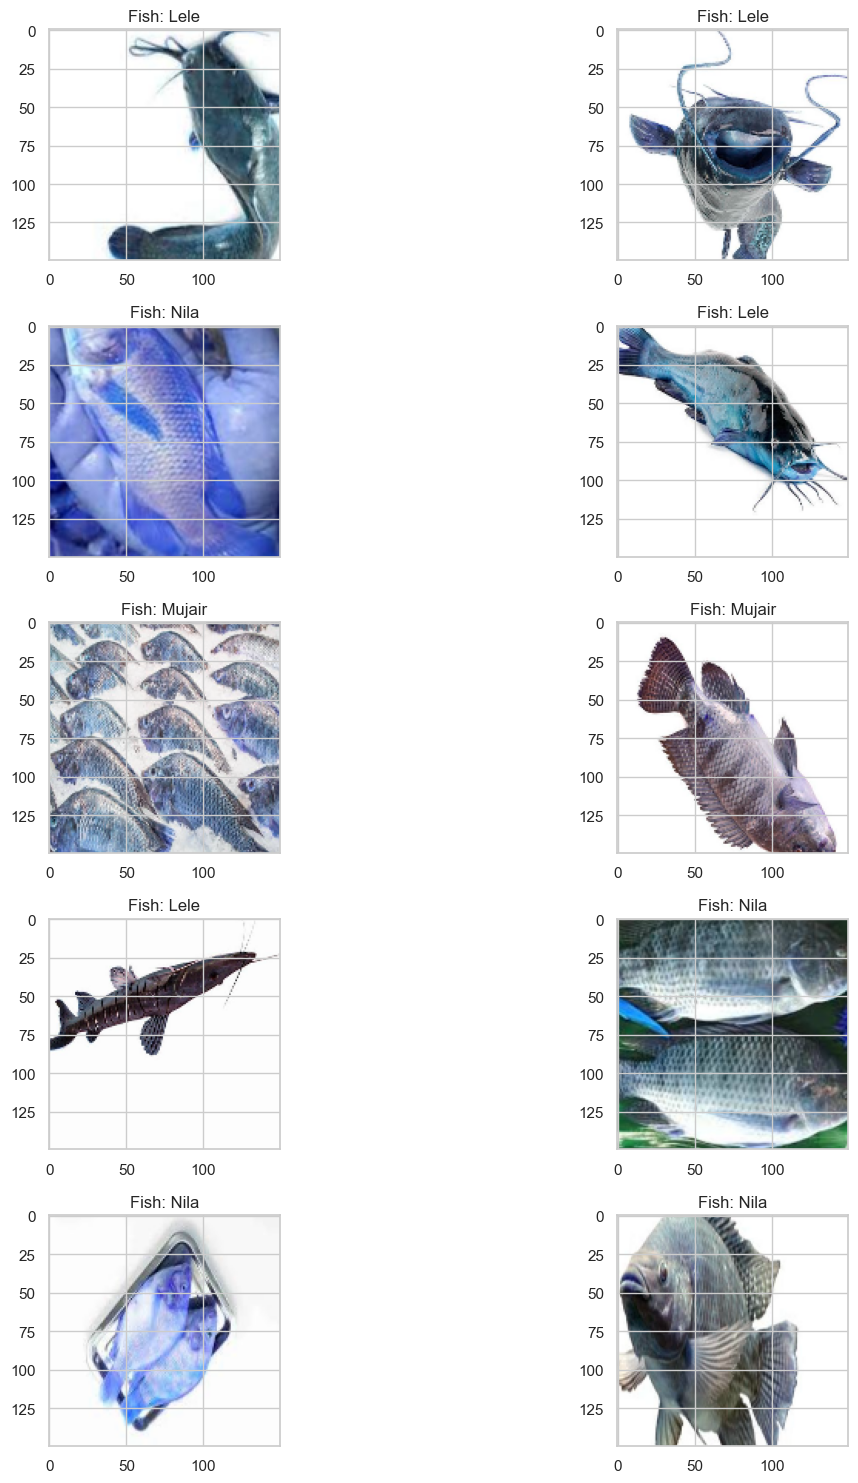

In [11]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Fish: '+Z[l])
        
plt.tight_layout()

In [12]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

In [13]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [14]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [15]:
print(tf.__version__)

2.10.0


In [16]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

In [56]:
batch_size=128
epochs=98

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [57]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [58]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 96)       0

In [60]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/98
14/14 [==============================] - 32s 2s/step - loss: 0.2578 - accuracy: 0.9091 - val_loss: 0.1649 - val_accuracy: 0.9317
Epoch 2/98
14/14 [==============================] - 28s 2s/step - loss: 0.1387 - accuracy: 0.9498 - val_loss: 0.2169 - val_accuracy: 0.9117
Epoch 3/98
14/14 [==============================] - 27s 2s/step - loss: 0.1226 - accuracy: 0.9533 - val_loss: 0.1511 - val_accuracy: 0.9367
Epoch 4/98
14/14 [==============================] - 28s 2s/step - loss: 0.1151 - accuracy: 0.9539 - val_loss: 0.1861 - val_accuracy: 0.9250
Epoch 5/98
14/14 [==============================] - 29s 2s/step - loss: 0.1355 - accuracy: 0.9450 - val_loss: 0.1866 - val_accuracy: 0.9133
Epoch 6/98
14/14 [==============================] - 32s 2s/step - loss: 0.1034 - accuracy: 0.9689 - val_loss: 0.1594 - val_accuracy: 0.9383
Epoch 7/98
14/14 [==============================] - 32s 2s/step - loss: 0.1385 - accuracy: 0.9510 - val_loss: 0.1600 - val_accuracy: 0.9333
Epoch 8/98
14/14 [==

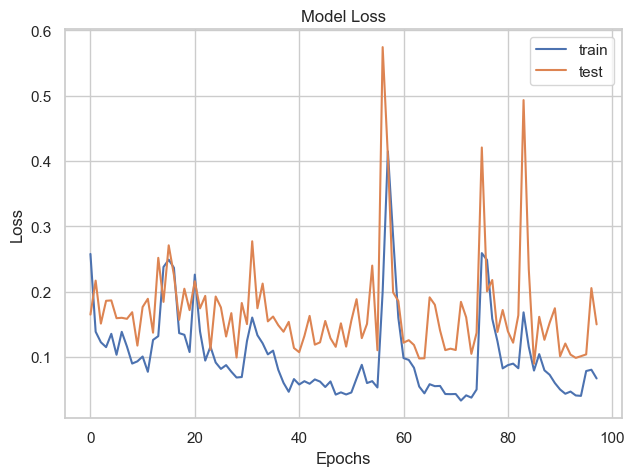

In [61]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

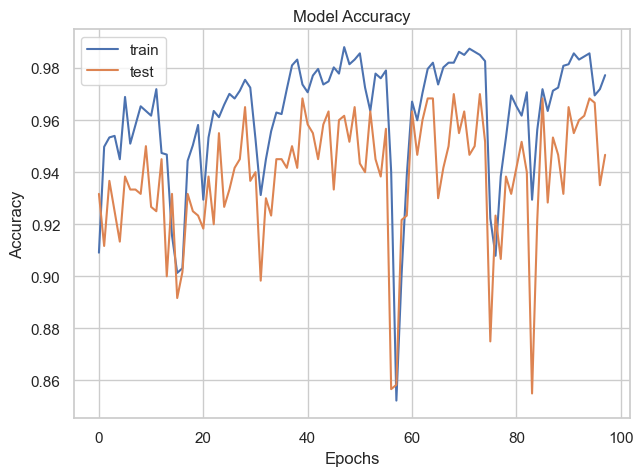

In [62]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [63]:
from sklearn.metrics import accuracy_score

# Mendapatkan indeks kelas dari prediksi dan kelas aktual
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)



19/19 [==============================] - 3s 123ms/step


In [65]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

In [66]:
# Print actual dan predicted labels untuk gambar yang terprediksi dengan benar
print("Actual and Predicted Labels for Correctly Classified Images:")
for i in range(len(prop_class)):
    actual_label = le.inverse_transform([np.argmax(y_test[prop_class[i]])])[0]
    predicted_label = le.inverse_transform([pred_digits[prop_class[i]]])[0]
    print(f"Image {prop_class[i] + 1}: Actual = {actual_label}, Predicted = {predicted_label}")

# Print actual dan predicted labels untuk gambar yang terprediksi dengan salah
print("\nActual and Predicted Labels for Misclassified Images:")
for i in range(len(mis_class)):
    actual_label = le.inverse_transform([np.argmax(y_test[mis_class[i]])])[0]
    predicted_label = le.inverse_transform([pred_digits[mis_class[i]]])[0]
    print(f"Image {mis_class[i] + 1}: Actual = {actual_label}, Predicted = {predicted_label}")


Actual and Predicted Labels for Correctly Classified Images:
Image 1: Actual = Mujair, Predicted = Mujair
Image 2: Actual = Mujair, Predicted = Mujair
Image 3: Actual = Nila, Predicted = Nila
Image 4: Actual = Mujair, Predicted = Mujair
Image 5: Actual = Mujair, Predicted = Mujair
Image 6: Actual = Lele, Predicted = Lele
Image 7: Actual = Nila, Predicted = Nila
Image 8: Actual = Mujair, Predicted = Mujair

Actual and Predicted Labels for Misclassified Images:
Image 27: Actual = Nila, Predicted = Mujair
Image 40: Actual = Nila, Predicted = Mujair
Image 62: Actual = Nila, Predicted = Mujair
Image 63: Actual = Mujair, Predicted = Nila
Image 71: Actual = Nila, Predicted = Mujair
Image 113: Actual = Mujair, Predicted = Nila
Image 136: Actual = Nila, Predicted = Mujair
Image 141: Actual = Nila, Predicted = Mujair


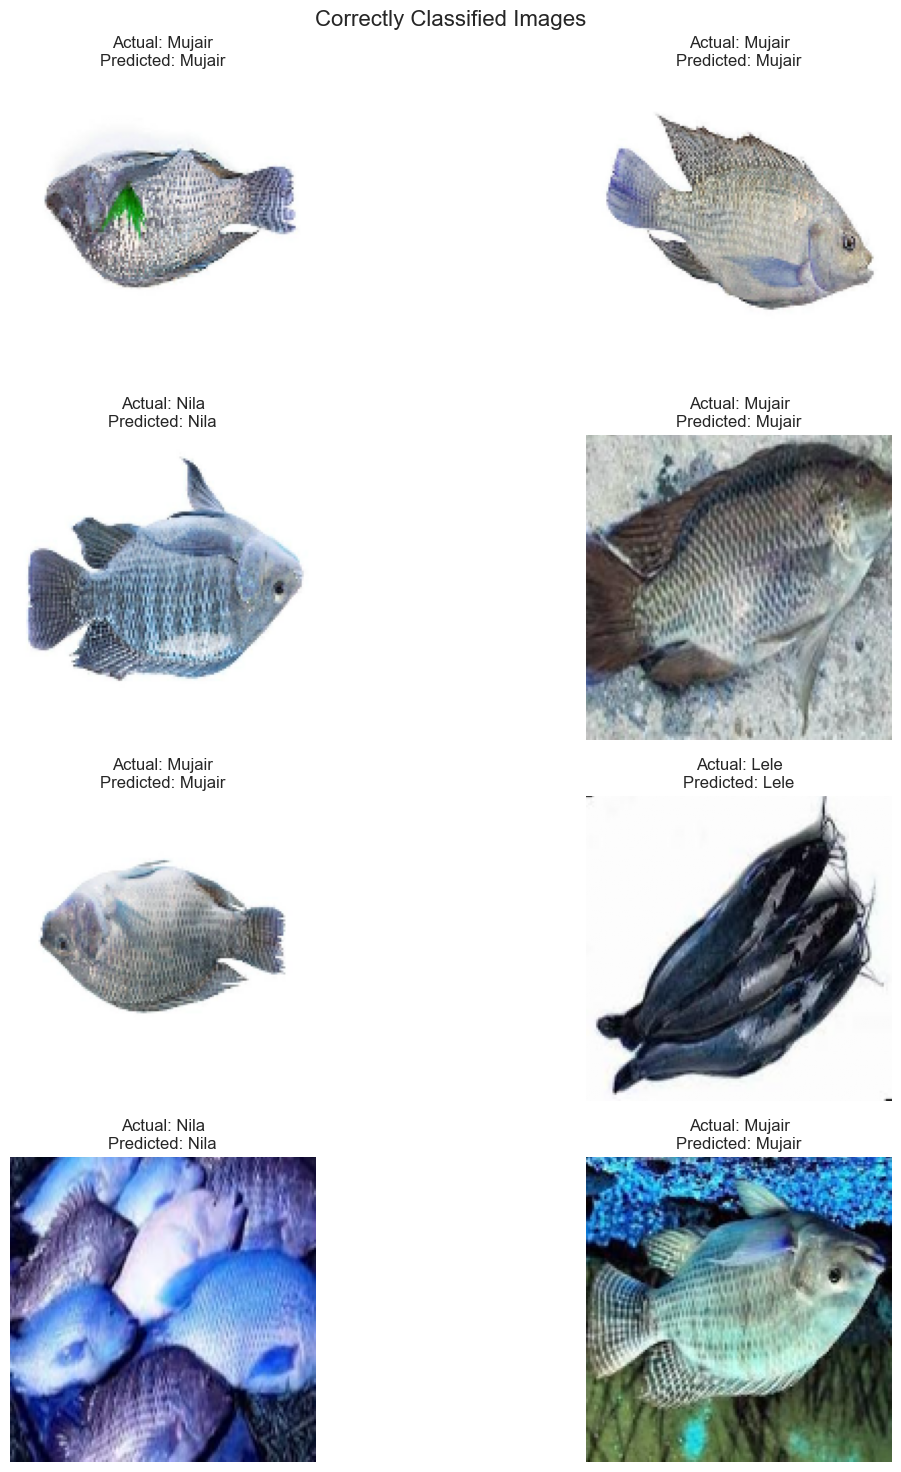

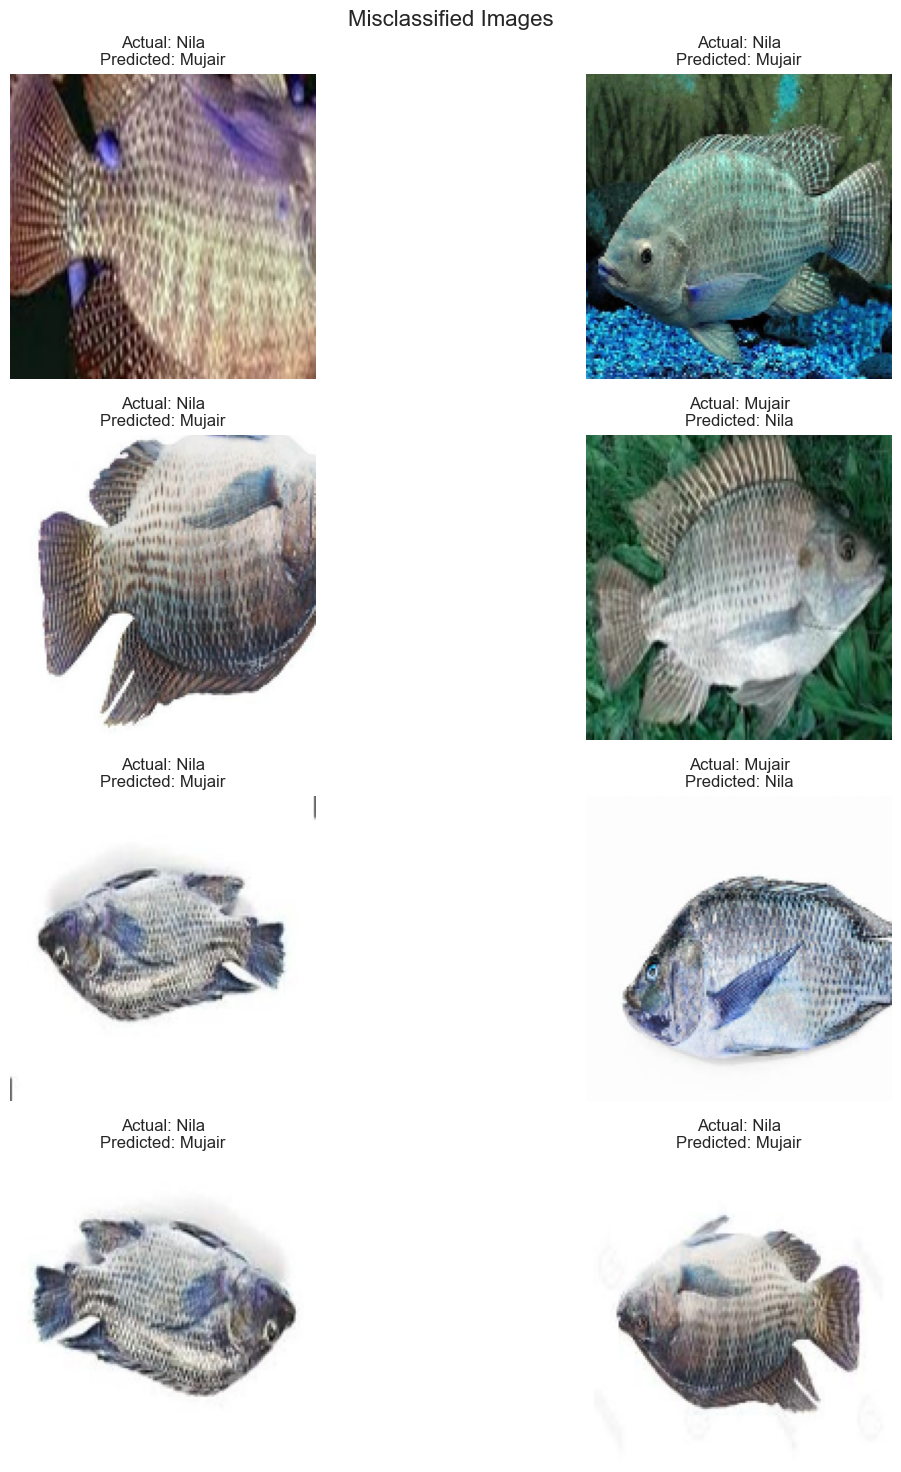

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Fungsi untuk menampilkan gambar dengan label aktual dan prediksi
def plot_images_with_labels(images, actual_labels, predicted_labels, title):
    fig, axes = plt.subplots(4, 2, figsize=(15, 15))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i])
        ax.set_title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_labels[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Fungsi untuk menampilkan plot untuk gambar yang terprediksi dengan benar dan yang terprediksi dengan salah
def display_classification_results(images, actual_labels, predicted_labels, title):
    fig, axes = plt.subplots(4, 2, figsize=(15, 15))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i])
        ax.set_title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_labels[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Membuat LabelEncoder
le = LabelEncoder()
le.classes_ = np.load("label_encoder_classes.npy")

# Plot gambar yang terklasifikasi dengan benar
correct_images = [x_test[idx] for idx in prop_class[:8]]
correct_actual_labels = [le.inverse_transform([np.argmax(y_test[idx])])[0] for idx in prop_class[:8]]
correct_predicted_labels = [le.inverse_transform([pred_digits[idx]])[0] for idx in prop_class[:8]]
display_classification_results(correct_images, correct_actual_labels, correct_predicted_labels, "Correctly Classified Images")

# Plot gambar yang terklasifikasi dengan salah
misclassified_images = [x_test[idx] for idx in mis_class[:8]]
misclassified_actual_labels = [le.inverse_transform([np.argmax(y_test[idx])])[0] for idx in mis_class[:8]]
misclassified_predicted_labels = [le.inverse_transform([pred_digits[idx]])[0] for idx in mis_class[:8]]
display_classification_results(misclassified_images, misclassified_actual_labels, misclassified_predicted_labels, "Misclassified Images")


In [68]:
from sklearn.metrics import accuracy_score

# Mendapatkan indeks kelas sebenarnya dari one-hot encoded labels
true_labels = np.argmax(y_test, axis=1)

# Menghitung akurasi
accuracy = accuracy_score(true_labels, pred_digits)
print(f"Total Accuracy: {accuracy * 100:.2f}%")


Total Accuracy: 94.67%


In [30]:
y_test

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

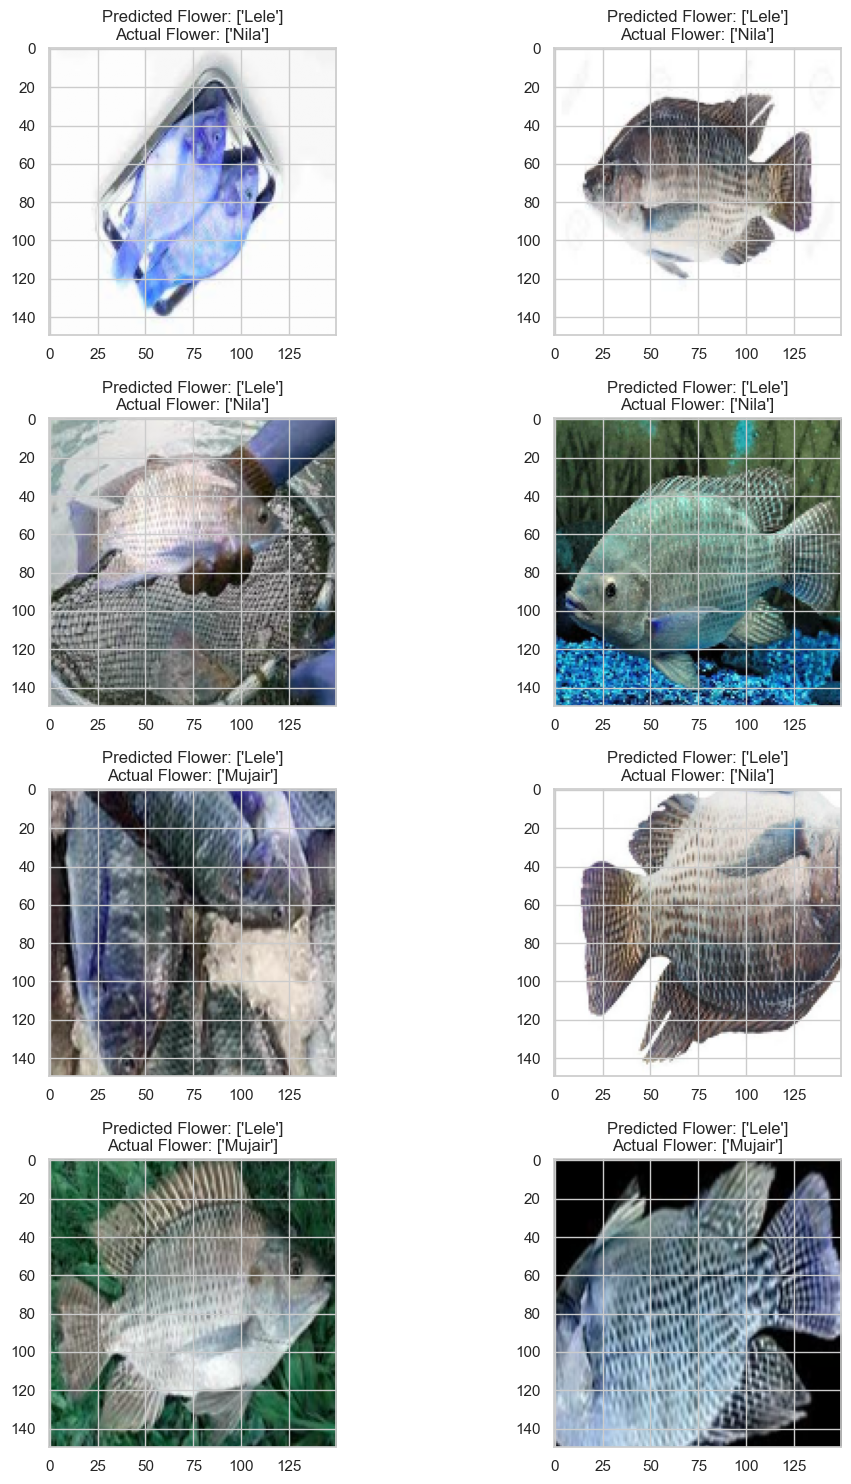

In [52]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(15, 15)

for i in range(4):
    for j in range(2):
        ax[i, j].imshow(x_test[mis_class[count]])
        
        # Menggunakan np.argmax untuk mendapatkan indeks kelas dari softmax
        predicted_class = np.argmax(pred_digits[mis_class[count]])
        actual_class = np.argmax(y_test[mis_class[count]])
        
        ax[i, j].set_title("Predicted Flower: " + str(le.inverse_transform([predicted_class])) + "\n" +
                           "Actual Flower: " + str(le.inverse_transform([actual_class])))
        plt.tight_layout()
        count += 1


In [69]:
from tensorflow.keras.models import save_model

# Gantilah 'model' dengan objek model Anda yang ingin disimpan
model.save("my_model3.h5", include_optimizer=True)
np.save("label_encoder_classes.npy", le.classes_)

In [ ]:
loaded_model.summary()

NameError: name 'loaded_model' is not defined

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Path ke gambar yang akan diprediksi
input_image_path = './fish-classification-cnn/Dataset/nila/1a89e2531df266977d6436e6c490bcd0.jpg'

# Membaca gambar
img = image.load_img(input_image_path, target_size=(150, 150))

# Mengubah gambar menjadi array numpy
img_array = image.img_to_array(img)

# Menambahkan dimensi tambahan karena model menerima input dengan bentuk (batch_size, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

# Normalisasi nilai piksel
img_array /= 255.0

# Melakukan prediksi
prediction = model.predict(img_array)

# Mendapatkan indeks kelas dengan probabilitas tertinggi
predicted_class = np.argmax(prediction)

# Mendapatkan label kelas dari indeks
predicted_label = le.inverse_transform([predicted_class])[0]

# Mencetak hasil prediksi
print(f'Predicted class: {predicted_label}')
print(f'Class probabilities: {prediction[0]}')
